In [7]:
#https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

In [82]:
import os
import tensorflow as tf
import tensorflow.contrib.eager as tfe
# tf.compat.v1.enable_eager_execution()
print(tf.__version__)

import time
import ingestor
import extractor2
import utils
import data
import functools

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

1.14.0


In [8]:
params = ingestor.get_params()

In [9]:
train_data = data.get_train_dataset(params)
parser = data.tristan_parser
train_parsed = train_data.map(functools.partial(parser, params=params))

In [10]:
# for i in train_parsed.take(1):
#     print(i)
# tf.Tensor(376967, shape=(), dtype=int64)

In [81]:
%%time
# set features and labels
features = {'goal': [], 'goal_asl': [], 'thms': [], 'thms_hard_negatives': []}
labels = {'tac_id': []}

# iterate over dataset to extract data into arrays. remove 'take' part to iterate over the entire dataset
for raw_record in train_parsed.take(TAKE):
    fx, lx = raw_record[0], raw_record[1]
    features['goal'].append(fx['goal'])
    features['goal_asl'].append(fx['goal_asl'])
    features['thms'].append(fx['thms'])
    features['thms_hard_negatives'].append(fx['thms_hard_negatives'])
    labels['tac_id'].append(lx['tac_id'])

# instantiate extractor object
ex = extractor2.Extractor(params)

# tokenize goals
temp = ex.tokenize(features['goal'], ex.vocab_table)
#pad all goals to be of length 1000
goal_list = []
for j in range(len(temp)):
        l = len(temp[j])
        h = tf.pad(temp[j], [[0, 1000-l]], constant_values=0)
        goal_list.append(h)
features['goal_ids'] = goal_list

# tokenize hypotheses. this requires more work since there may be more than one hypothesis
length = len(features['goal'])
features['goal_asl_ids'] = []

for i in range(length):
    temp = ex.tokenize(features['goal_asl'][i], ex.vocab_table)
    #pad all hypotheses to be of length 1000
    hypo_list = []
    for j in range(len(temp)):
        l = len(temp[j])
        h = tf.pad(temp[j], [[0, 1000-l]], constant_values=0)
        hypo_list.append(h)
    features['goal_asl_ids'].append(hypo_list)

del features['goal']
del features['goal_asl']
del features['thms']
del features['thms_hard_negatives']

# FEATURES
# 'goal_ids': an array of LENGTH OF DATASET containing arrays which are the tokenized goals of length 1000
# below is an example of how to access the entire array as numpy arrays
# print(features['goal_ids'][0].numpy())
# 'goal_asl_ids': this below is an array of LENGTH OF DATASET containing lists of tokenized hypotheses 
# where each hypothesis is of length 1000. below is an example of how to access the first hypothesis 
# from the list of hypotheses corresponding to the first training example
# print(features['goal_asl_ids'][0][0].numpy())

# LABELS
# 'tac_id': array containing tactic ids. below is an example of how to access the first tactic
# print(labels['tac_id'][0].numpy())

CPU times: user 58.9 s, sys: 641 ms, total: 59.5 s
Wall time: 1min 1s


In [13]:
tf.shape(features['goal_ids'])

<tf.Tensor: id=1153513, shape=(2,), dtype=int32, numpy=array([10000,  1000], dtype=int32)>

In [14]:
tf.shape(labels['tac_id'])

<tf.Tensor: id=1153516, shape=(1,), dtype=int32, numpy=array([10000], dtype=int32)>

In [74]:
## More succing version of creatig a dataset
## Need to understand how to do batching
def DataframeCreator():
    
    #create an array of features
    features_array = np.zeros((TAKE,1000))
    for i,x in enumerate(features['goal_ids']):
        features_array[i] = x
    
    #create an array of labels
    labels_array = np.zeros((TAKE))
    for i,x in enumerate(labels['tac_id']):
        labels_array[i] = x
        
    
    # put these together in a pandas dataframe
    # perhaps not the most efficient thing but allows for correct types 
    # and quick data analysis
    
    #not necessary to have col names but since we will also be adding hypothesis this may be necessary 
    feature_cols = []
    for i in range(1000):
        feature_cols.append("h" + str(i))
        
    dataset = pd.DataFrame(features_array, columns= feature_cols)
    dataset["label"] = labels_array
    
    return dataset
        
    
    

In [75]:
df = DataframeCreator()

In [79]:
df.describe()

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h991,h992,h993,h994,h995,h996,h997,h998,h999,label
count,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.0,6.062100,6.791900,10.385900,4.162500,7.329400,6.159900,8.433700,9.727800,21.249800,...,1.744800,1.555500,1.570500,1.480700,1.702100,1.402500,1.555000,1.494100,1.454900,16.457500
std,0.0,0.427156,1.314598,18.970777,2.914814,10.792467,9.282271,16.599619,17.868885,24.797941,...,12.080185,11.598732,11.058863,10.666555,15.288215,9.394111,14.311634,9.803182,9.985627,12.425105
min,2.0,6.000000,6.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.0,6.000000,6.000000,4.000000,4.000000,5.000000,4.000000,6.000000,7.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,2.0,6.000000,6.000000,9.000000,4.000000,7.000000,4.000000,7.000000,7.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
75%,2.0,6.000000,9.000000,9.000000,4.000000,7.000000,5.000000,7.000000,7.000000,26.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000
max,2.0,9.000000,18.000000,140.000000,166.000000,420.000000,300.000000,828.000000,728.000000,828.000000,...,439.000000,763.000000,607.000000,615.000000,821.000000,606.000000,731.000000,303.000000,569.000000,40.000000


In [92]:
def TrainTestSets(dataset):
    '''here features and labels are in one object not sure if that is an issue, 
followed a tutorial buy may have to split?'''

    train, test = train_test_split(dataset, test_size=0.2)
    target_train = train.pop("label")
    Train = tf.data.Dataset.from_tensor_slices((train.values, target_train.values))
    Train2 = Train.shuffle(len(train)).batch(1)
    
    
    target_test = test.pop("label")
    Test = tf.data.Dataset.from_tensor_slices((test.values, target_test.values))
    Test2 = Test.shuffle(len(test)).batch(1)

    return Train2, Test2
    


In [93]:
train_object, test_object = TrainTestSets(df)

In [94]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(100, activation='sigmoid')
  ])
    
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [97]:
model = get_compiled_model()
for i in range(1):
    model.fit(train_object, epochs=2)
    test_loss, test_acc = model.evaluate(test_object, verbose=2)

Epoch 1/2
8000/8000 [==============================] - 59s 7ms/step - loss: 7607.3617 - acc: 0.9850
Epoch 2/2
8000/8000 [==============================] - 57s 7ms/step - loss: 7606.1873 - acc: 0.9909
2000/2000 - 5s - loss: 7470.0469 - acc: 0.9950


(array([1.450e+02, 1.600e+01, 1.220e+02, 1.443e+03, 8.000e+01, 1.710e+03,
        1.000e+00, 2.100e+01, 6.590e+02, 2.000e+00, 7.700e+01, 1.000e+00,
        2.100e+01, 5.720e+02, 0.000e+00, 9.110e+02, 4.310e+02, 1.000e+00,
        1.000e+00, 4.900e+01, 0.000e+00, 5.000e+00, 4.690e+02, 5.000e+00,
        4.350e+02, 9.000e+00, 2.360e+02, 8.600e+01, 3.320e+02, 3.900e+01,
        0.000e+00, 2.020e+02, 3.030e+02, 3.900e+01, 8.800e+01, 3.000e+00,
        1.800e+01, 1.300e+03, 6.800e+01, 8.500e+01, 1.500e+01]),
 array([ 0.        ,  0.97560976,  1.95121951,  2.92682927,  3.90243902,
         4.87804878,  5.85365854,  6.82926829,  7.80487805,  8.7804878 ,
         9.75609756, 10.73170732, 11.70731707, 12.68292683, 13.65853659,
        14.63414634, 15.6097561 , 16.58536585, 17.56097561, 18.53658537,
        19.51219512, 20.48780488, 21.46341463, 22.43902439, 23.41463415,
        24.3902439 , 25.36585366, 26.34146341, 27.31707317, 28.29268293,
        29.26829268, 30.24390244, 31.2195122 , 32.195

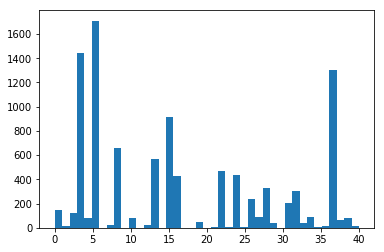

In [96]:
import matplotlib.pyplot as plt 
lables = df['label']
plt.hist(lables, bins=41)